In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")

import numpy as np
import matplotlib.pyplot as plt
import analysis_tools

import environments

plt.style.use("project_style.mplstyle")
import matplotlib

pane_size = plt.rcParams["figure.figsize"][0]

if trajectories := True:
    dataset_type = "trajectories"
else:
    dataset_type = "points"

In [2]:
train_dataset = np.load(f"../datasets/{dataset_type}/train_dataset.npz")  # load dataset
val_dataset = np.load(f"../datasets/{dataset_type}/val_dataset.npz")

### Metadata

In [3]:
for name, dataset in zip(("Train", "Val"), (train_dataset, val_dataset)):
    print(f"{name} dataset:")
    print(f"{'Entry:':8} {'Shape:':15} {'dtype:':10}")
    for var in dataset:
        print(f"{var:8} {str(dataset[var].shape):15} {dataset[var].dtype}")

Train dataset:
Entry:   Shape:          dtype:    
r        (12000, 500, 2) float32
v        (12000, 500, 2) float32
c        (12000, 500, 6) float32
Val dataset:
Entry:   Shape:          dtype:    
r        (3000, 500, 2)  float32
v        (3000, 500, 2)  float32
c        (3000, 500, 6)  float32


### Plot Random Example Trajectories

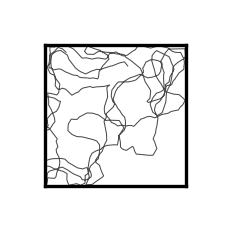

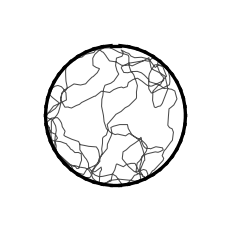

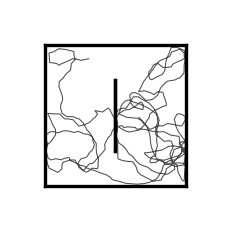

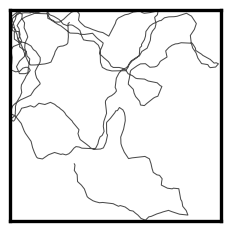

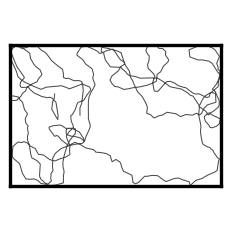

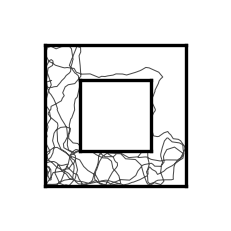

In [4]:
def plot_envs(environments, pane_size = 1):
        
    collage = ["square", "circle", "walled_square", 
               "large_square", "rectangle", "square_toroid"]
    
    rows = 2
    cols = 3
    _, r, _, c = analysis_tools.test_dataset(collage, 500) # create dataset
    lim = np.amax(np.abs(r))*1.1

    pane_size *= 0.5

    for i in range(len(collage)):
        fig, ax = plt.subplots(1,1, figsize = (pane_size*cols, pane_size*rows))
        ax.plot(r[i,:,0], r[i,:,1], "k", linewidth = 0.25, alpha = 0.7)
        ax.set_aspect("equal")
        ax.axis([-lim, lim, -lim, lim])
        ax.axis("off")

        for wall in environments.envs[collage[i]]:
            ax.plot(wall[:,0], wall[:,1], "k")
        fig.savefig(f"figures/dataset_panel/env{i}")
plot_envs(environments.Environments())


### Inspect dataset distributions 

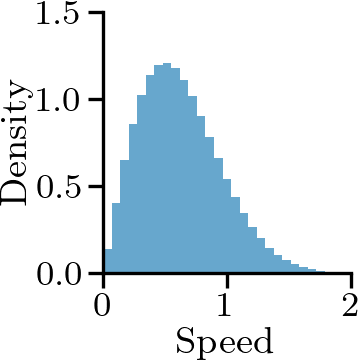

In [5]:
r_train = train_dataset["r"][:]
c_train = train_dataset["c"][:]

labels = ["Square", "Circle", "Large Square", "Rectangle", "Walled Square", "Square Toroid"]

# env id is index of first non-zero element
env_id = np.argmax(c_train[:,0], axis = -1)


if trajectories:
    v_train = train_dataset["v"][:]
    s_train = np.linalg.norm(v_train, axis = -1)

    fig, ax =  plt.subplots(1, figsize = (pane_size, pane_size))
    ax.hist(s_train.ravel(), bins = 40, density = True, alpha = 0.75)
    ax.axis([0, 2, 0, 1.5])
    ax.set_xlabel("Speed")
    ax.set_ylabel("Density")
    plt.subplots_adjust(wspace =0, hspace = 0)
    plt.tight_layout()
    #plt.savefig("figures/speed_distribution")

### Distribution of head directions (for trajectories)

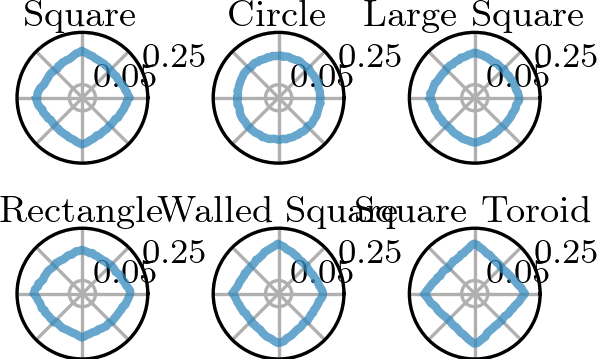

In [6]:
if trajectories:
    hd_train = np.arctan2(v_train[...,1], v_train[...,0])

    # hist expects left edge of first bin, right egde of last
    theta = np.linspace(-np.pi, np.pi, 100) 
    fig = plt.figure(figsize = (3/2*pane_size, pane_size))
    eval_theta = theta[:-1] + (theta[1]-theta[0])/2 # evaluate at bin centers

    for i in range(c_train.shape[-1]):
        mask = env_id == i

        ax = plt.subplot(2, 3, i+1, polar = True)
        ax.set_title(labels[i])

        hist, _ = np.histogram(hd_train[mask].ravel(), bins = theta, density = True)
        ax.plot(eval_theta, hist, "-", alpha = 0.75,linewidth = 2)
        ax.set_yticks([0.05, 0.25])
        ax.set_xticklabels([])

    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    #plt.savefig("figures/hd_distributions.svg")

### Lastly, we inspect the visitation distributions

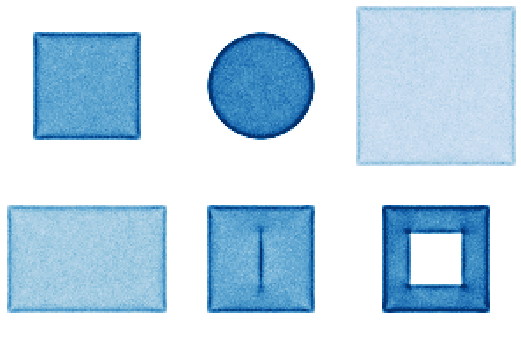

In [7]:
fig =  plt.figure(figsize = (3*pane_size, pane_size))

env_id = np.argmax(c_train[:,0], axis = -1) # env id is index of first non-zero element

bins = np.linspace(-1.5, 1.5, 100)*1.1

for i in range(c_train.shape[-1]):
    mask = list(env_id == i)
    ax = fig.add_subplot(2, 3, i+1)
    u = r_train[mask]
    hist = np.histogram2d(r_train[mask][...,0].ravel(), r_train[mask][...,1].ravel(), bins, density = True)[0]
    hist[hist == 0] = np.nan

    if i == 0:
        vmax = np.nanmax(hist) # calibrate wrt. small quare

    im = ax.imshow(hist.T, origin = "upper", vmin = 0, vmax = vmax)

    #ax.set_title(labels[i])
    ax.axis("off")
    
plt.subplots_adjust(wspace=-0.75, hspace=0.) 
#plt.savefig("figures/visitation_density")

(0.0, 1.0, 0.0, 1.0)

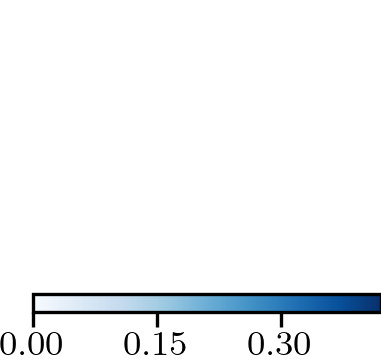

In [8]:
cbar_fig = plt.figure(figsize = (pane_size, pane_size))
ax = plt.subplot(111)

cbar = fig.colorbar(im, ax = ax, shrink = 1, location = "bottom", ticks = [0, 0.15, 0.3])
ax.axis("off")
#plt.savefig("figures/visitation_density_cbar")